# GSI (Group Synchronization Index) toolkit

This notebook introduces **GSI**, a simple metric for measuring how well football players move together, using tracking data.

The toolkit allows you to:
1) measure local synchrony using Delaunay triangles,
2) measure synchrony for any user-defined group of players,
3) visualize synchrony on the pitch,
4) animate synchrony over time.


## Method summary

**Goal:** measure how synchronized are players in reacting and moving together during the game.


### Directional alignment

First, it is checked whether players are moving in the same direction.

For each player, the direction of movement relative to the ball is computed.
Directional alignment is then measured using a Kuramoto-style order parameter:

$$
R_{\text{dir}}(t)
=
\left|
\frac{1}{N}
\sum_{k=1}^{N}
e^{i \phi_k(t)}
\right|
$$

where $\phi_k(t)$ is the movement direction of player $k$ relative to the ball.

- $R_{\text{dir}} = 1$ → players move in the same direction  
- $R_{\text{dir}} = 0$ → players move in different directions  

This term captures shared movement intent.


### Speed consistency

Next, it is checked whether players are moving at a similar pace.

Speed consistency is computed by measuring how different player speeds are within the group:

$$
R_{\text{speed}}(t)
=
\exp\left(
- \frac{\operatorname{std}\big(v_1(t), \dots, v_N(t)\big)}{\sigma_v}
\right)
$$

- high value → players move at similar speeds  
- low value → players move at very different speeds  

This term has a small weight, since perfect speed matching is not always expected in football.


### Delta-acceleration (impulse) consistency

Finally, it is measured whether players start, stop, or change speed at the same moment.

Instead of using raw acceleration, the change in acceleration is used:

$$
\Delta a_k(t) = a_k(t) - a_k(t-1)
$$

Impulse consistency is defined as:

$$
R_{\text{imp}}(t)
=
\exp\left(
- \frac{\operatorname{std}\big(\Delta a_1(t), \dots, \Delta a_N(t)\big)}{\sigma_a}
\right)
$$

- high value → players react at the same time  
- low value → players react at different times  

This term captures synchronized reactions, such as pressing or collective movement shifts.


### Final Group Synchronization Index

The final **Group Synchronization Index (GSI)** is a weighted combination of the three components:

$$
\text{GSI}(t)
=
w_1 R_{\text{dir}}(t)
+
w_2 R_{\text{speed}}(t)
+
w_3 R_{\text{imp}}(t),
\qquad
\sum_i w_i = 1
$$

Default weights in this toolkit are $w_1=0.5$ (direction), $w_2=0.3$ (speed), and $w_3=0.2$ (impulse), but they can be adjusted depending on the analysis goal.

The resulting score is always between **0 and 1**:
- **1** → players move and react together  
- **0** → players act independently  

GSI can be computed for:
- local player groups (Delaunay triangles),
- any user-defined group of players.


In [25]:
import sys
sys.path.append("src")

import importlib.util
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import HTML

from data_utils import load_skillcorner_match, split_tracking_by_team


In [26]:
code_path = Path("src/code.py")
spec = importlib.util.spec_from_file_location("tracking_code", code_path)
tracking_code = importlib.util.module_from_spec(spec)
spec.loader.exec_module(tracking_code)

synchTracking = tracking_code.synchTracking


In [27]:
match_id = 1886347
dataset, tracking_df, events_df, phases_df, meta, players_df, team_names = load_skillcorner_match(
    match_id=match_id,
    sample_rate=0.5,
    limit=300,
    flatten_tracking=True,
    only_first_half=True,
)

In [28]:
tracking_home_df, tracking_away_df, home_ids, away_ids = split_tracking_by_team(tracking_df, players_df)
fps = float(dataset.metadata.frame_rate)

tracking_home_kin = synchTracking.compute_player_kinematics(tracking_home_df, fps=fps)
tracking_away_kin = synchTracking.compute_player_kinematics(tracking_away_df, fps=fps)

## Triangle synchrony (Delaunay)
We build Delaunay triangles per frame, then compute synchrony for each triangle.

In [29]:
triangles_home = synchTracking.build_delaunay_per_frame(tracking_home_df)
sync_tri_home = synchTracking.compute_triangle_synchrony(tracking_home_kin, triangles_home)

(<Figure size 1200x700 with 2 Axes>,
 <Axes: title={'center': 'Triangle synchrony - frame 28'}>)

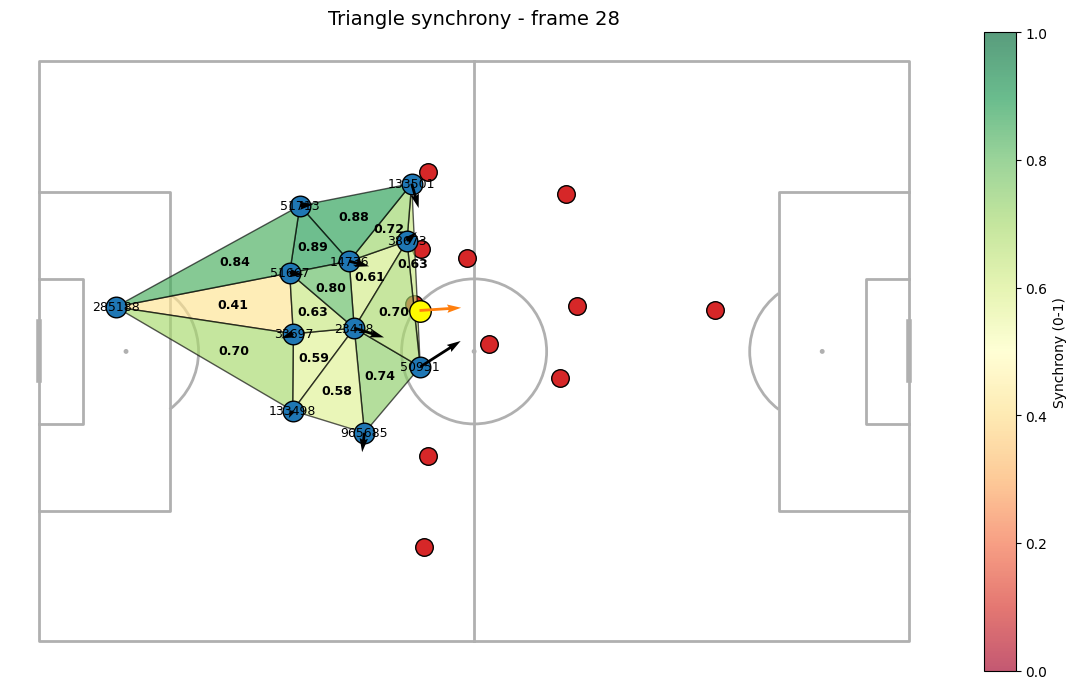

In [30]:
frame_id = int(tracking_home_df["frame_id"].iloc[0])
synchTracking.plot_triangle_synchrony_on_pitch_mpl(
    tracking_team_df=tracking_home_kin,
    sync_df=sync_tri_home,
    frame_id=frame_id,
    opponent_df=tracking_away_kin,
)

### Triangle animation

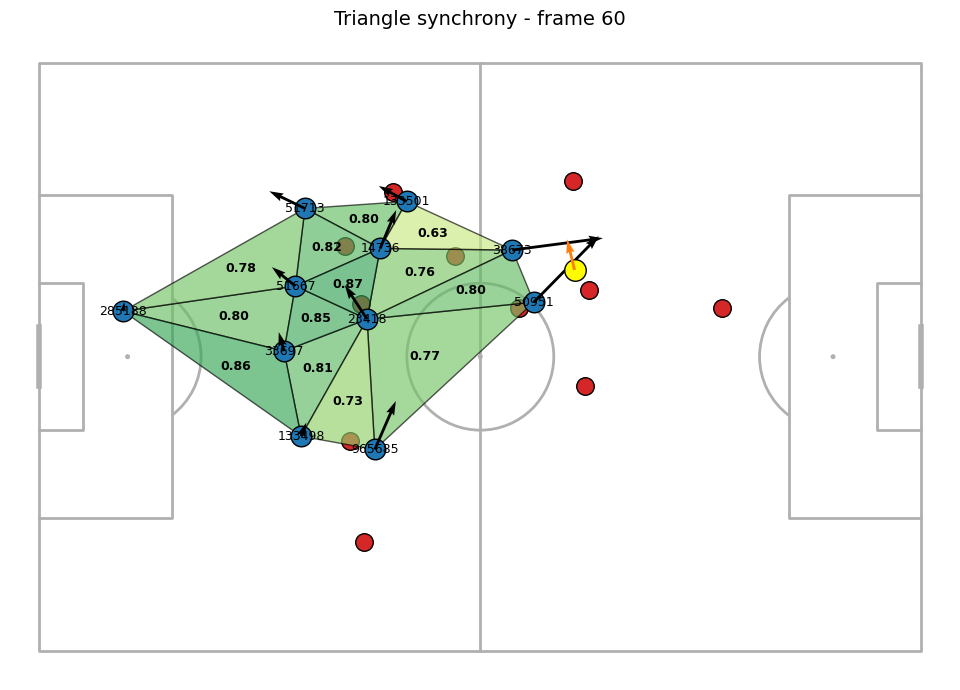

In [31]:
fig, anim = synchTracking.animate_triangle_synchrony_on_pitch_mpl(
    tracking_team_df=tracking_home_kin,
    sync_df=sync_tri_home,
    start_time="00:00:05.0",
    end_time="00:00:10.0",
    interval=150,
    opponent_df=tracking_away_kin,
)
HTML(anim.to_jshtml())


## Group synchrony (custom PID list)
We compute synchrony for a user-defined group of players.

In [32]:
home_def = [51713, 51667, 33697, 133498]
away_def = [50983, 176224, 51649, 735578]

In [33]:
home_sync = synchTracking.group_sync_over_time(
    tracking_home_kin, home_def, start_time="00:00:05.0", end_time="00:00:25.0"
)
away_sync = synchTracking.group_sync_over_time(
    tracking_away_kin, away_def, start_time="00:00:05.0", end_time="00:00:25.0"
)


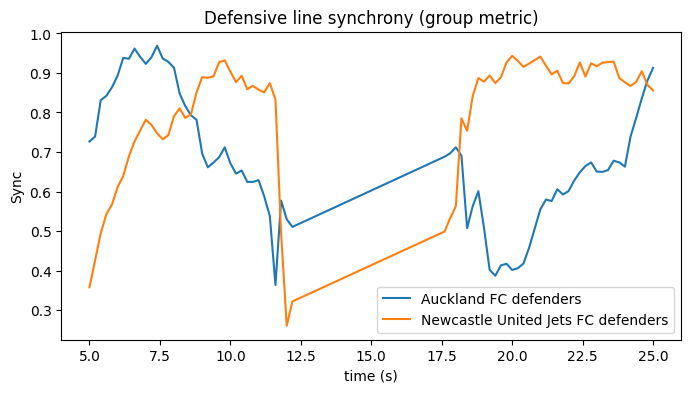

In [34]:
home_ts = tracking_home_kin[["frame_id", "timestamp"]].drop_duplicates()
away_ts = tracking_away_kin[["frame_id", "timestamp"]].drop_duplicates()
home_plot = home_sync.merge(home_ts, on="frame_id", how="left")
away_plot = away_sync.merge(away_ts, on="frame_id", how="left")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(home_plot["timestamp"].dt.total_seconds(), home_plot["Sync"], label=f"{team_names.get('home','HOME')} defenders")
ax.plot(away_plot["timestamp"].dt.total_seconds(), away_plot["Sync"], label=f"{team_names.get('away','AWAY')} defenders")
ax.set_xlabel("time (s)")
ax.set_ylabel("Sync")
ax.set_title("Defensive line synchrony (group metric)")
ax.legend()
plt.show()


### Group visualization (single frame)

(<Figure size 1200x700 with 1 Axes>,
 <Axes: title={'center': 'Group sync - frame 28'}>)

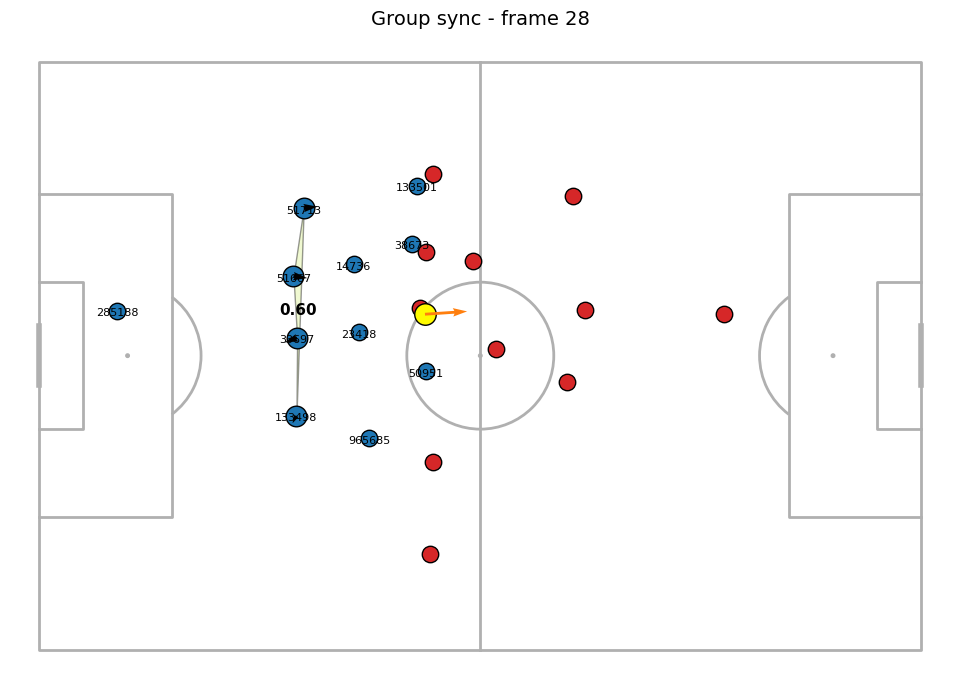

In [35]:
frame_id = int(tracking_home_df["frame_id"].iloc[0])
synchTracking.plot_group_sync_on_pitch(
    tracking_team_df=tracking_home_kin,
    pids=home_def,
    frame_id=frame_id,
    opponent_df=tracking_away_kin,
)

### Group animation

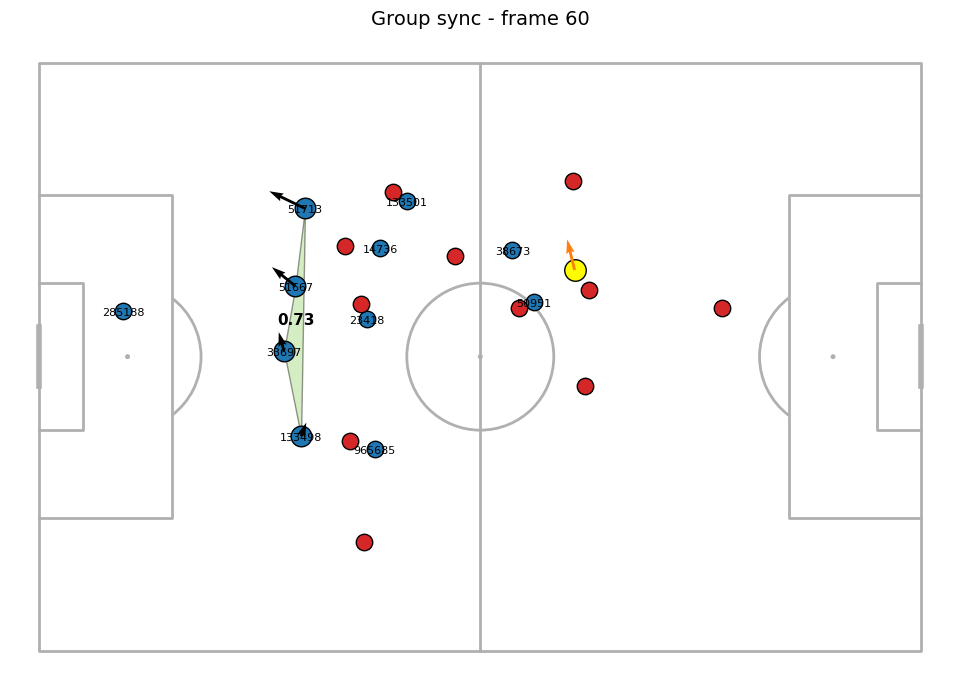

In [ ]:
fig, anim = synchTracking.animate_group_sync_on_pitch(
    tracking_team_df=tracking_home_kin,
    pids=home_def,
    start_time="00:00:05.0",
    end_time="00:00:10.0",
    interval=150,
    opponent_df=tracking_away_kin,
)
HTML(anim.to_jshtml())

#animations cant be seen on github view - you need to run it locally to be able to see it